In [1]:
from matplotlib import pyplot as plt 

In [2]:
import json
from pprint import pprint

In [3]:
import json

In [4]:
import re

In [5]:
import numpy as np

In [6]:
def bucket(x, size):
    l = len(x)
    buckets = []
    i = 0
    while i < l:
        buckets.append(sum(x[i:i+size])/len(x[i:i+size]))
        i+=size
    return buckets

In [7]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [8]:
class LogReader():
    def __init__(self, filename, keys):
        self.file = open(f'{filename}')
        self.keys = set(keys)
        self.matches = {}
        for key in keys:
            self.matches[key]=[]
    
    def grab(self):
        line = next(self.file, None)
        while line:
            split = line.strip().split('=')
            if len(split)==2:
                query = split[0]
                value = float(split[1])
                if query in self.keys:
                    self.matches[query].append(value)
            line = next(self.file, None)
        return self.matches

In [9]:
tasks = [
    ('atac_region', 'gene'),
    ('gene', 'atac_region'),
    ('gene', 'protein_name'),
    ('protein_name', 'gene'),
]

In [10]:
base_keys = [
    'train zero one loss',
    'train value loss',
    'train prediction loss',
    'validation zero one loss',
    'validation value loss',
    'validation prediction loss',
]

keys = []
for key in base_keys:
    for task in tasks:
        keys.append(f'{key} {task}')

In [11]:
keys += [
    'Outer step',
]

In [12]:
readers = {}
matches = {}

#### Timestamp of run

In [106]:
timestamps = [
    '20211102-1131',
    '20211102-1454',
    '20211102-1455',
    '20211102-1456',
    '20211103-0958',
]
files = [f'logs/train_earl_{tmstp}.log' for tmstp in timestamps]

In [107]:
for file in files:
    if file not in readers:
        readers[file] = LogReader(file, keys)
        matches = readers[file].grab()

## Select File

In [108]:
idx = 4

## Get matching log lines

In [109]:
file = files[idx]
matches = readers[file].grab()

## Parameters of this run

In [110]:
pprint(json.load(open(f'logs/earl_params_{timestamps[idx]}.json')))

{'atac_ones_weight': 1,
 'checkpoint': 40,
 'device': 'cuda:1',
 'gene_ones_weight': 1,
 'inner_lr': 0.01,
 'inner_steps': 5,
 'layers': [['GATConv', {'concat': False, 'heads': 2, 'out_channels': 32}],
            ['GATConv', {'concat': False, 'heads': 2, 'out_channels': 32}],
            ['GATConv', {'concat': False, 'heads': 2, 'out_channels': 32}],
            ['GATConv', {'concat': False, 'heads': 2, 'out_channels': 32}]],
 'mode': 'reptile',
 'n_steps': 10000,
 'out_mlp': {'bias': True,
             'dim_in': 32,
             'dim_inner': 512,
             'dim_out': 1,
             'num_layers': 3},
 'outer_lr': 0.1,
 'target_heads': False,
 'train_batch_size': 10,
 'validation_batch_size': 10}


## Current Step

In [111]:
batch = matches['Outer step'][-1]
batch

3.0

## Training loss

('atac_region', 'gene') 0.6616


IndexError: list index out of range

<Figure size 1080x720 with 0 Axes>

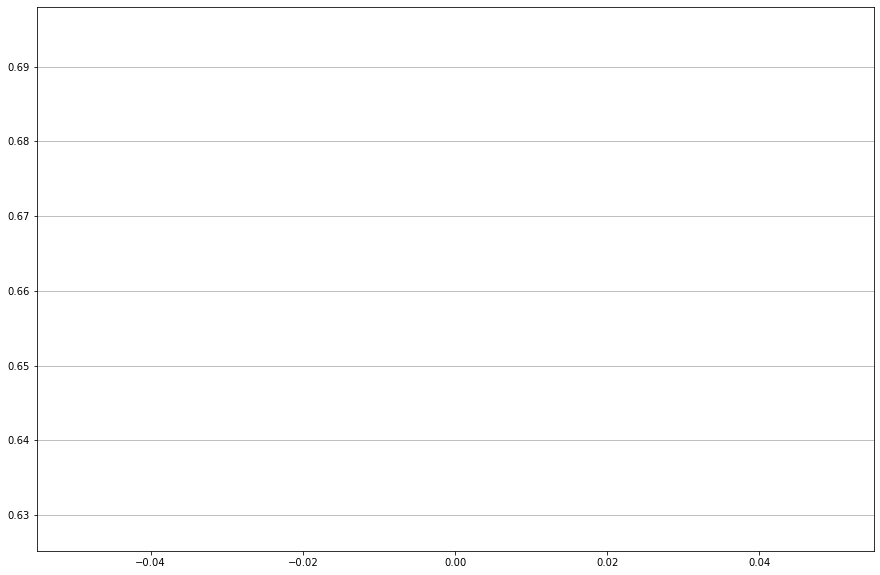

In [112]:
plt.figure(figsize=(15,10))
fig,ax = plt.subplots(figsize=(15,10))
plt.grid(axis='y')

for task in tasks:
    training_loss = matches[f'train prediction loss {task}']
    ax.plot(training_loss[0:], label=f'{task[0]}-{task[1]}')
    print(task, f'{training_loss[-1]:.4f}')
_=ax.legend()


('atac_region', 'gene') 0.3343027561903
('gene', 'atac_region') 0.056203148886561395
('gene', 'protein_name') 0.2413390353322029
('protein_name', 'gene') 0.3048525393009186


<Figure size 1080x720 with 0 Axes>

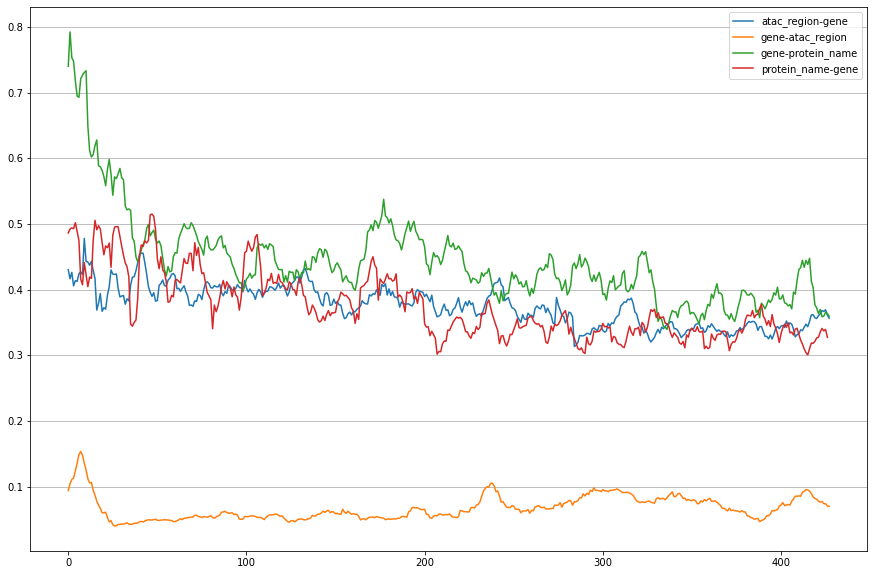

In [102]:
plt.figure(figsize=(15,10))
fig,ax = plt.subplots(figsize=(15,10))
plt.grid(axis='y')

for task in tasks:
    training_loss = matches[f'train prediction loss {task}']
    ax.plot(moving_average(training_loss[5:],10), label=f'{task[0]}-{task[1]}')
    print(task, training_loss[-1])
_=ax.legend()


## Validation Loss

('atac_region', 'gene') 0.30592755079269407
('gene', 'atac_region') 0.08940282240509988
('gene', 'protein_name') 0.4112200424075127
('protein_name', 'gene') 0.33337166905403137


<Figure size 1080x720 with 0 Axes>

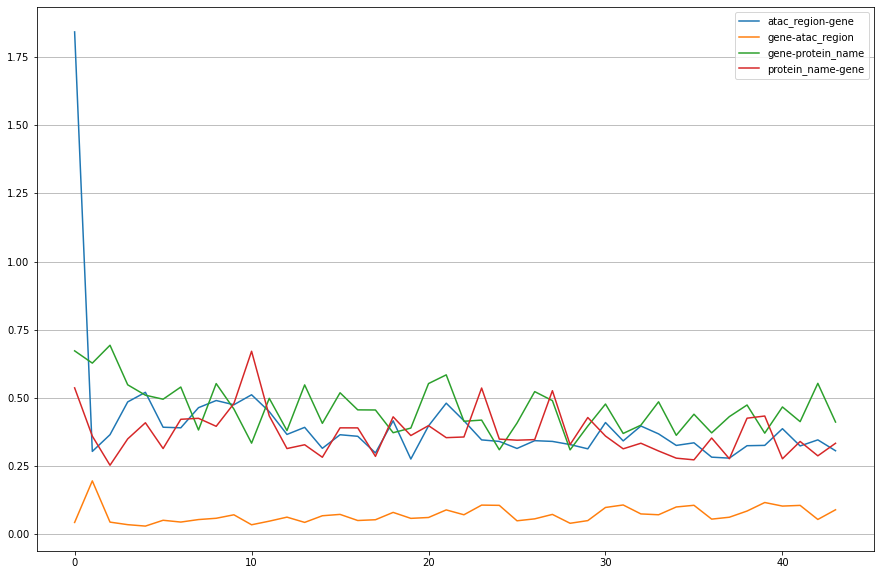

In [103]:
plt.figure(figsize=(15,10))
fig,ax = plt.subplots(figsize=(15,10))
plt.grid(axis='y')

for task in tasks:
    validation_loss = matches[f'validation prediction loss {task}']
    _=ax.plot(moving_average(validation_loss,1), label=f'{task[0]}-{task[1]}')
#     _=ax.plot(validation_loss, label=f'{task[0]}-{task[1]}')
    print(task, validation_loss[-1])
_=ax.legend()

## Sample predictions

In [104]:
import time

In [105]:
prediction_file = open(f'logs/train_earl_prediction_sample_{timestamps[idx]}.log')

for line in prediction_file:
    print(line.strip(), flush=True)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Task: ('protein_name', 'gene')
--------------------------------------------------------------------------------
batch 1759 0      pred,y:   0.000 0.000
batch 1759 1      pred,y:   1.048 0.000
batch 1759 2      pred,y:   0.951 0.000
batch 1759 3      pred,y:   0.000 0.000
batch 1759 4      pred,y:   0.000 0.000
batch 1759 5      pred,y:   0.000 0.000
batch 1759 6      pred,y:   0.000 0.000
batch 1759 7      pred,y:   1.051 0.000
batch 1759 8      pred,y:   0.000 0.000
batch 1759 9      pred,y:   0.000 0.000
batch 1759 10     pred,y:   0.000 0.000
batch 1759 11     pred,y:   0.000 0.000
batch 1759 12     pred,y:   0.000 0.000
batch 1759 13     pred,y:   0.000 0.000
batch 1759 14     pred,y:   0.000 0.000
batch 1759 15     pred,y:   0.000 0.000
batch 1759 16     pred,y:   0.000 0.000
batch 1759 17     pred,y:   0.000 0.000
batch 1759 18     pred,y:   0.000 0.000
batch 1759 19     pred,y:   0.000 0.000
batch 1759 20     pred,y:   0.000 0.796
batch 1759 21     pred,y:   0.000 0.000
batch 17

batch 1759 203    pred,y:   1.079 0.000
batch 1759 204    pred,y:   1.056 0.000
batch 1759 205    pred,y:   0.000 0.000
batch 1759 206    pred,y:   0.000 0.000
batch 1759 207    pred,y:   0.000 0.000
batch 1759 208    pred,y:   0.000 0.000
batch 1759 209    pred,y:   0.000 0.000
batch 1759 210    pred,y:   0.000 0.000
batch 1759 211    pred,y:   0.000 0.000
batch 1759 212    pred,y:   0.000 0.000
batch 1759 213    pred,y:   1.060 0.796
batch 1759 214    pred,y:   0.912 0.000
batch 1759 215    pred,y:   0.000 0.000
batch 1759 216    pred,y:   1.478 1.233
batch 1759 217    pred,y:   0.000 0.000
batch 1759 218    pred,y:   0.000 0.796
batch 1759 219    pred,y:   0.000 0.000
batch 1759 220    pred,y:   0.000 0.000
batch 1759 221    pred,y:   0.968 0.000
batch 1759 222    pred,y:   0.000 0.000
batch 1759 223    pred,y:   0.000 0.000
batch 1759 224    pred,y:   0.000 0.796
batch 1759 225    pred,y:   0.000 0.000
batch 1759 226    pred,y:   0.000 0.000
batch 1759 227    pred,y:   0.000 0.000


batch 1759 103    pred,y:   0.000 0.000
batch 1759 104    pred,y:   0.547 0.612
batch 1759 105    pred,y:   0.649 1.135
batch 1759 106    pred,y:   0.000 0.000
batch 1759 107    pred,y:   0.695 1.135
batch 1759 108    pred,y:   0.627 0.352
batch 1759 109    pred,y:   0.629 1.135
batch 1759 110    pred,y:   0.000 0.000
batch 1759 111    pred,y:   0.591 0.352
batch 1759 112    pred,y:   0.674 0.818
batch 1759 113    pred,y:   0.000 1.135
batch 1759 114    pred,y:   0.878 0.818
batch 1759 115    pred,y:   0.978 1.135
batch 1759 116    pred,y:   1.092 0.818
batch 1759 117    pred,y:   1.498 1.135
batch 1759 118    pred,y:   0.641 0.000
batch 1759 119    pred,y:   0.464 0.352
batch 1759 120    pred,y:   0.000 0.352
batch 1759 121    pred,y:   1.213 0.352
batch 1759 122    pred,y:   0.000 0.818
batch 1759 123    pred,y:   0.661 1.262
batch 1759 124    pred,y:   1.553 0.989
batch 1759 125    pred,y:   0.663 0.000
batch 1759 126    pred,y:   0.000 0.612
batch 1759 127    pred,y:   1.553 0.352


batch 1759 170    pred,y:   1.286 0.000
batch 1759 171    pred,y:   0.000 0.000
batch 1759 172    pred,y:   0.000 0.000
batch 1759 173    pred,y:   0.000 0.856
batch 1759 174    pred,y:   0.000 0.000
batch 1759 175    pred,y:   1.263 1.621
batch 1759 176    pred,y:   0.000 0.000
batch 1759 177    pred,y:   1.081 0.000
batch 1759 178    pred,y:   1.111 0.000
batch 1759 179    pred,y:   0.000 0.000
batch 1759 180    pred,y:   1.107 0.000
batch 1759 181    pred,y:   0.000 0.000
batch 1759 182    pred,y:   0.000 0.000
batch 1759 183    pred,y:   0.000 0.000
batch 1759 184    pred,y:   0.943 0.000
batch 1759 185    pred,y:   0.000 0.000
batch 1759 186    pred,y:   0.000 0.000
batch 1759 187    pred,y:   0.000 0.000
batch 1759 188    pred,y:   0.000 0.000
batch 1759 189    pred,y:   0.000 0.000
batch 1759 190    pred,y:   1.068 0.000
batch 1759 191    pred,y:   0.000 0.000
batch 1759 192    pred,y:   0.000 0.000
batch 1759 193    pred,y:   0.000 0.000
batch 1759 194    pred,y:   0.000 0.000


batch 1759 71     pred,y:   0.030 0.000
batch 1759 72     pred,y:   0.021 0.000
batch 1759 73     pred,y:   0.014 0.000
batch 1759 74     pred,y:   0.028 0.000
batch 1759 75     pred,y:   0.019 0.000
batch 1759 76     pred,y:   0.034 0.000
batch 1759 77     pred,y:   0.032 0.000
batch 1759 78     pred,y:   0.022 0.000
batch 1759 79     pred,y:   0.016 0.000
batch 1759 80     pred,y:   0.022 0.000
batch 1759 81     pred,y:   0.027 0.000
batch 1759 82     pred,y:   0.038 0.000
batch 1759 83     pred,y:   0.039 0.000
batch 1759 84     pred,y:   0.032 0.000
batch 1759 85     pred,y:   0.025 0.000
batch 1759 86     pred,y:   0.027 0.000
batch 1759 87     pred,y:   0.031 0.000
batch 1759 88     pred,y:   0.012 0.000
batch 1759 89     pred,y:   0.031 0.000
batch 1759 90     pred,y:   0.017 0.000
batch 1759 91     pred,y:   0.018 0.000
batch 1759 92     pred,y:   0.030 0.000
batch 1759 93     pred,y:   0.039 0.000
batch 1759 94     pred,y:   0.026 0.000
batch 1759 95     pred,y:   0.031 0.000


batch 1759 276    pred,y:   0.027 0.000
batch 1759 277    pred,y:   0.034 0.000
batch 1759 278    pred,y:   0.022 0.000
batch 1759 279    pred,y:   0.033 0.000
batch 1759 280    pred,y:   0.021 0.000
batch 1759 281    pred,y:   0.034 0.000
batch 1759 282    pred,y:   0.024 0.000
batch 1759 283    pred,y:   0.035 0.000
batch 1759 284    pred,y:   0.029 0.000
batch 1759 285    pred,y:   0.034 0.000
batch 1759 286    pred,y:   0.019 0.000
batch 1759 287    pred,y:   0.022 0.000
batch 1759 288    pred,y:   0.035 0.000
batch 1759 289    pred,y:   0.031 0.000
batch 1759 290    pred,y:   0.104 0.000
batch 1759 291    pred,y:   0.031 0.000
batch 1759 292    pred,y:   0.032 0.000
batch 1759 293    pred,y:   0.034 0.000
batch 1759 294    pred,y:   0.041 0.000
batch 1759 295    pred,y:   0.035 0.000
batch 1759 296    pred,y:   0.026 0.000
batch 1759 297    pred,y:   0.023 0.000
batch 1759 298    pred,y:   0.031 0.000
batch 1759 299    pred,y:   0.035 0.000
